<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/Pixel_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
(ds_train, ds_test), ds_info = tfds.load('mnist', 
                              split=['test', 'test'], 
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)

def binarize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image / 255.)
    return image, tf.cast(image, tf.int32)

ds_train = ds_train.map(binarize)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_test = ds_test.map(binarize).batch(64).cache().prefetch(64)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
class MaskedConv2D(tf.keras.layers.Layer):

    def __init__(self, mask_type, kernel = 5, filters = 1):
        super(MaskedConv2D, self).__init__()
        self.kernel = kernel
        self.filters = filters
        self.mask_type = mask_type
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(self.kernel,
                                        self.kernel,
                                        input_shape[-1],
                                        self.filters),
                                  initializer='glorot_normal',
                                  trainable=True)
        self.b = self.add_weight(shape=(self.filters,), trainable=True, initializer='zeros')

        mask = np.ones(self.kernel**2, dtype=np.float32)
        center = len(mask) // 2
        mask[center+1:] = 0
        if self.mask_type == 'A':
            mask[center] = 0
        mask = mask.reshape((self.kernel, self.kernel, 1, 1))
        self.mask  = tf.constant(mask, dtype=tf.float32)
    
    def call(self, inputs):
        masked_w = tf.math.multiply(self.w, self.mask)
        output = tf.nn.conv2d(inputs, masked_w, 1, padding='SAME') + self.b
        return tf.nn.relu(output)

In [4]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, h=32):
        super(ResidualBlock, self).__init__()

        self.forward = tf.keras.models.Sequential([
            MaskedConv2D('B', kernel=1, filters=h),
            MaskedConv2D('B', kernel=3, filters=h),
            MaskedConv2D('B', kernel=1, filters=2*h)
        ])
    
    def call(self, inputs):
        return self.forward(inputs) + inputs

In [5]:
def SimplePixelCNN(hidden_features=64,
                   output_features=64,
                   num_resblocks=7):
    inputs = Input(shape=(28, 28, 1), dtype=tf.float32)
    x = inputs

    x = MaskedConv2D('A', kernel=7, filters=2*hidden_features)(x)

    for _ in range(num_resblocks):
        x = ResidualBlock(hidden_features)(x)
    
    x = Conv2D(output_features, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name='PixelCNN')

In [6]:
pixelCNN = SimplePixelCNN()
pixelCNN.summary()

Model: "PixelCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
masked_conv2d (MaskedConv2D) (None, 28, 28, 128)       6400      
_________________________________________________________________
residual_block (ResidualBloc (None, 28, 28, 128)       53504     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 28, 28, 128)       53504     
_________________________________________________________________
residual_block_2 (ResidualBl (None, 28, 28, 128)       53504     
_________________________________________________________________
residual_block_3 (ResidualBl (None, 28, 28, 128)       53504     
_________________________________________________________________
residual_block_4 (ResidualBl (None, 28, 28, 128)       535

In [7]:
pixelCNN.compile(
    optimizer='rmsprop',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.losses.BinaryCrossentropy()]
)

pixelCNN.fit(ds_train, epochs=50, validation_data=ds_test)

Epoch 1/50
157/157 [==============================] - 49s 93ms/step - loss: 0.1405 - binary_crossentropy: 0.1405 - val_loss: 0.1074 - val_binary_crossentropy: 0.1074
Epoch 2/50
157/157 [==============================] - 14s 89ms/step - loss: 0.1024 - binary_crossentropy: 0.1025 - val_loss: 0.1165 - val_binary_crossentropy: 0.1165
Epoch 3/50
157/157 [==============================] - 14s 90ms/step - loss: 0.0978 - binary_crossentropy: 0.0978 - val_loss: 0.0954 - val_binary_crossentropy: 0.0954
Epoch 4/50
157/157 [==============================] - 14s 90ms/step - loss: 0.0946 - binary_crossentropy: 0.0946 - val_loss: 0.0951 - val_binary_crossentropy: 0.0951
Epoch 5/50
157/157 [==============================] - 14s 90ms/step - loss: 0.0924 - binary_crossentropy: 0.0924 - val_loss: 0.0922 - val_binary_crossentropy: 0.0922
Epoch 6/50
157/157 [==============================] - 14s 90ms/step - loss: 0.0910 - binary_crossentropy: 0.0910 - val_loss: 0.0903 - val_binary_crossentropy: 0.0903
Epoc

In [ ]:
grid_row = 5
grid_col = 5

batch = grid_row * grid_col
h = w = 28
images = np.ones((batch, w, h, 1), dtype=np.float32)

for row in range(h):

    for col in range(w):

        prob = pixelCNN.predict(images)[:,row,col,0]

        pixel_samples = tf.random.categorical(tf.math.log(np.stack([1-prob, prob],1)), 1)

        images[:,row,col,0] = tf.reshape(pixel_samples,[batch])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The 'renderer' parameter of tight_layout() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'renderer', they should be pass as keyword, not positionally.
  if __name__ == '__main__':


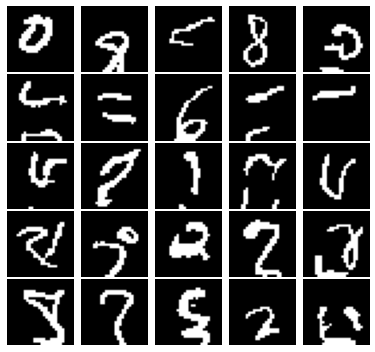

In [16]:
f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1,grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()